## First attempt

First inspired by the images in [Sue Liu's blog](https://builtin.com/data-science/dirichlet-distribution)
which use the code from [this repo](https://github.com/yusueliu/medium/blob/master/scripts/plot_dirichlet.py).
The code below is very different from Liu's because Liu does 2D 
plots using a triangular grid and triangular mesh (`matplotlib.tri`, see [the matplotlib docs demo](https://matplotlib.org/stable/gallery/images_contours_and_fields/triplot_demo.html)), 
and maps from xy-coordinates to the simplex coordinate space.  This
is a mathematically principled approach, but here to make the code more transparent,
we've done a 3D scatterplot for points
confined to the simplex plane.  This avoids doing coordinate transformations
and steers clear of the specific machinery of the `tri` module.

The idea is to apply dirichlet.pdf to  a 2D array AA each of whose row vectors is
a valid theta (a vector in R3 that is on the simplex).  The result is a 1D array D we use to assign colors
to a 3D scatter plot of the rows of AA.

Color normalization helps here.  Either norm="log"  or norm= "power" gives somewhat better
information, especially for the last row.  But for more consistent improvement
see the second implementation in this notebook, which uses `ax.imshow` on 2D matrixes.

In [160]:
B =  np.concatenate([np.ravel(xv)[:,np.newaxis],np.ravel(yv)[:,np.newaxis]],axis=1)

In [167]:
(A[:,1] == B[:,1]).all()

True

In [161]:
A.shape,B.shape

((10000, 2), (10000, 2))

In [195]:
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.stats import dirichlet
import numpy as np

n=100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
xv, yv = np.meshgrid(x, y)
#A = np.concatenate([np.ravel(xv)[np.newaxis,:],np.ravel(yv)[np.newaxis,:]]).T
# A.shape is (10000, 2)
A = np.concatenate([np.ravel(xv)[:,np.newaxis],np.ravel(yv)[:,np.newaxis]],axis=1)

Z = 1 - A.sum(axis=1)
AA = np.concatenate([A,Z[:,np.newaxis]],axis=1)
# No neg values in the Z col.  This is the final constraint to restrict the AA rows to the simplex
AA = AA[(AA[:,2] > 0)]


# Avoid zero vals for any data coordinate: issues for dirichlet.pdf for alpha vals < 1
# Also backs us away from simplex boundaries because the pdf computation is unstable there.
AA = AA[(AA[:,0] != 0)&(AA[:,1] != 0)]


#### Roughly Equiv to previous two code-lines but leads to improper prob dists
# trim AA down to xy vals projecting onto the simplex (x+y) < 1
#AA = AA[(AA[:,2] >= 0)]

# NB clipping creates points whose coords dont exactly sum to 1.
#tol=1.e-3
#np.clip(AA,tol,1-tol,out=AA)

AA is a 2D array containing a sample of the 3D 2-simplex (the set of points in 3D space whose coordinates 
are all positive and add to 1).

In [196]:
display(AA.shape)
print(AA[23,:],AA[23,:].sum())

(4753, 3)

[0.24242424 0.01010101 0.74747475] 1.0


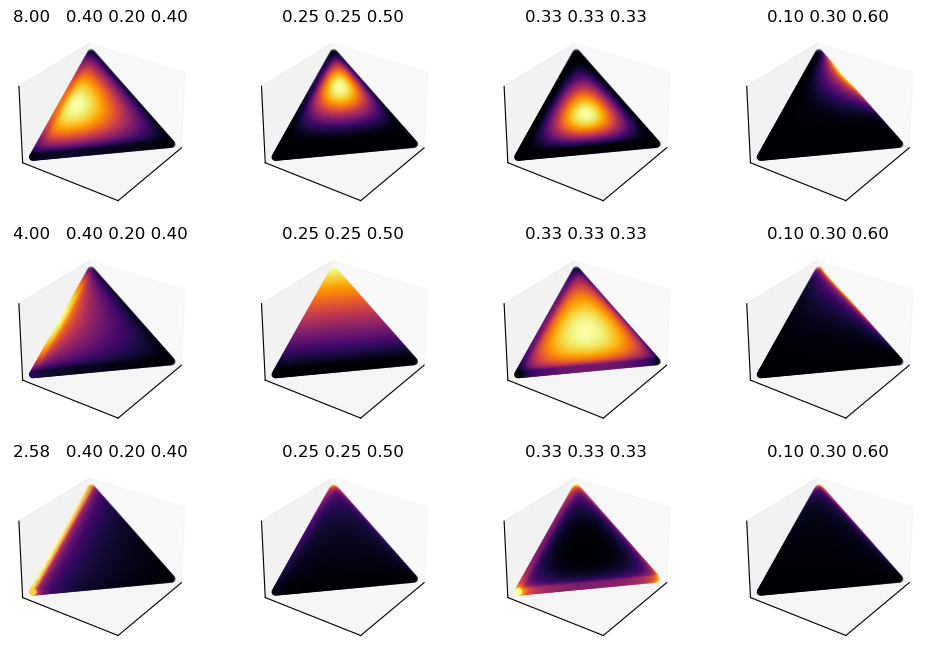

In [204]:
fig = plt.figure(figsize=(12,8))


conc = np.array([8,4,2.58])
# Proper prob dists
#dist = np.array([[.4,.2,.4],[.25,.25,.5],[.33333,.33334,.33333],[.1,.3,.6]])
#dist = np.array([[.8,.4,.8],[.49,.49,.98],[.85,.85,.85],[.49,.98,1.48]])
dist = np.array([[.4,.2,.4],[.25,.25,.5],[.33333,.33333,.33333],[.1,.3,.6]])
idx = 1
#elev,azim=20,30
elev,azim=30,35
#cmap="viridis"
cmap="inferno"
#norm="log"
norm="power"
#  Any old value.  Use no norm
#norm = 0

for (i,ctr) in enumerate(range(len(conc))):
    for (j,d) in enumerate(range(len(dist))):  
        ax = fig.add_subplot(3,4,idx, projection='3d') 
        alpha = conc[i] * dist[j]
        D = np.apply_along_axis(lambda x:dirichlet.pdf(x,alpha),arr=AA,axis=1)   
        if norm == "power":
            norm = colors.PowerNorm(gamma=0.4)
        elif norm == "log":
            norm=colors.LogNorm(vmin=0.01, vmax=D.max())
        else:
            norm=None
        ax.scatter(AA[:,0],AA[:,1],AA[:,2],c=D,cmap=cmap,norm=norm)
        ax.view_init(elev=elev, azim=azim,)
        if j== 0:
            ax.set_title(f"{conc[i]:.2f}   {dist[j][0]:.2f} {dist[j][1]:.2f} {dist[j][2]:.2f}") 
        else:
            ax.set_title(f"{dist[j][0]:.2f} {dist[j][1]:.2f} {dist[j][2]:.2f}")
        ax.set_xticks([],[])
        ax.set_yticks([],[])
        ax.set_zticks([],[])
        idx+=1
                          

As a sanity check we reproduce the picture in Sue Liu's blog to see if we are rendering the alphas
the same way.

We also compare the results of using `scipy.stats.dirichlet` with the `Dirichlet` class 
provided by Sue Liu (no difference found here).

In [82]:
from math import gamma
from functools import reduce
from operator import mul

class Dirichlet:
    """Define the Dirichlet distribution with vector parameter alpha."""
    def __init__(self, alpha):
        
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha])
    
    def pdf(self, x):
        """Returns pdf value for `x`. """
        return self._coef * reduce(mul, [xx ** (aa-1) for (xx, aa) in zip(x, self._alpha)])


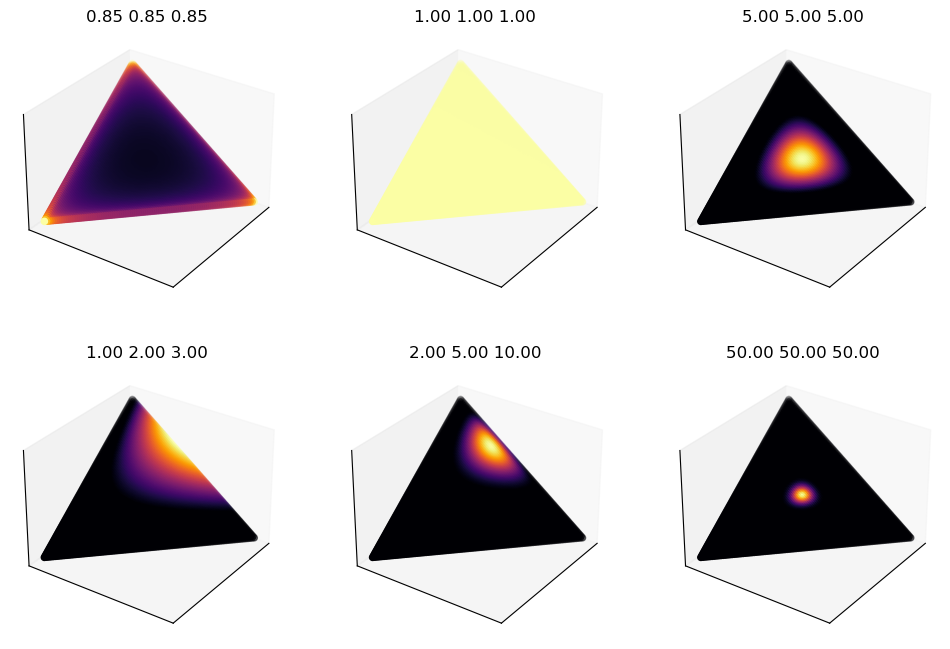

In [188]:
fig = plt.figure(figsize=(12,8))



alphas = np.array([[[.85,.85,.85],[1,1,1],[5,5,5]],
                  [[1,2,3],[2,5,10],[50,50,50]]])
idx = 1
elev,azim=30,35
cmap="inferno"
#cmap="viridis"
vmin=1.5
#vmin=0
#vmin=None
use_dirichlet_class = True

for i in range(alphas.shape[0]):
    for j in range(alphas.shape[1]):  
        ax = fig.add_subplot(2,3,idx, projection='3d') 
        alpha = alphas[i][j]
        if use_dirichlet_class:
            dch = Dirichlet(alpha)
            D = np.apply_along_axis(dch.pdf,arr=AA,axis=1) 
        else:
            D = np.apply_along_axis(lambda x:dirichlet.pdf(x,alpha),arr=AA,axis=1)   
        ax.scatter(AA[:,0],AA[:,1],AA[:,2],c=D,cmap=cmap,vmin=vmin)
        ax.view_init(elev=elev, azim=azim,)
        ax.set_title(f"{alpha[0]:.2f} {alpha[1]:.2f} {alpha[2]:.2f}") 
        ax.set_xticks([],[])
        ax.set_yticks([],[])
        ax.set_zticks([],[])
        idx+=1
              

The one significant imaging isue was for the alpha value (1,1,1) which defines the uniform distrubution
over thetas.  In this case dirichlet.pdf  uniformly
provides a color value of 2 for the scattered points, 
which by default gets rendered as black (color value is everywhere 
at its minimum).  This can be remedied by stipulating that the minimun color 
value is actually 1.5 (`vmin = 1.5` for `ax.scatter`), so
that a color value of 2 gets rendered as pale yellow using the colormap `inferno` (low end
of the color scale).

In [7]:
alpha = alphas[0][1]
print(alpha)
dch = Dirichlet(alpha)
D = np.apply_along_axis(dch.pdf,arr=AA,axis=1) 
D.min(),D.max()

[1. 1. 1.]


(2.0, 2.0)

Comparing a different alpha:

In [8]:
alpha = alphas[0][2]
print(alpha)
dch = Dirichlet(alpha)
D = np.apply_along_axis(dch.pdf,arr=AA,axis=1) 
D.min(),D.max()

[5. 5. 5.]


(6.298530385445104e-10, 11.866416027367105)

## Second attempt

Use `ax.imshow`.  No 3D.  Each image is a 2D array containing the relevant simplex points
above the diagonal.

The advantage of this is first, that some aspects of the visualization are better highlighted;
and second, you can add a light source for further highlighting.  The downside
of this second advantage is the light source can create shadows that are not always
helpful. Below we show results with and without a light source.

Even without a light source, yoiu can achieve significant improvements in discriminability
of the models if you tinker with the normalization of the colormap.  Below
we use log and power normalizations.

#### Outside the image loop

In [83]:
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.stats import dirichlet
import numpy as np

def f(theta):
    """
    Apply dirichlet.pdf to theta.
    
    Assumption: Three topic model.  theta is a 2D vector [x,y]
    
    Let z = 1-(x+y)
    Return dirichlet([x,y,z], alpha)
    
    Error catching: Return 0 if z is neg or 0 or x or y is 0.
    Intercepting these thetas because 
    no 0 vals are allowed in theta by scipy implementation (when alpha values are less than 1?).
    """
    global alpha
    x,y = theta
    if x == 0 or y == 0:
        return 0
    z = 1 - (x + y)
    if z <= 0:
        return 0
    a = np.array([x,y, z])
    try:
        return dirichlet.pdf(a,alpha)
    except:
        print("Dirichlet error:", a)
        return 0

# Factor alphas into a concentration scalar and a basemeasure probability distribution (sums to 1)
# with no loss of generality
conc = np.array([8,4,1])
base_measure = np.array([[.4,.2,.4],[.25,.25,.5],[.33333,.33334,.33333],[.1,.3,.6]])

### Construct W the basic data, a 2D image array for which Dirichlet values will
### be computed (for the points above the diagonal where  x+y < 1) 
### matplotlib image origin is upper left hand corner.
n=100
# x.min() is 0, x.max() is 1.  x has length n.
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
## xv and yv are 2D arrays representing the x- y- coords of points in a rectangular region
## in [xmin,xmax, ymin, ymax]
## xv[i,j] is the x-coord of the point i increments from xmin and j increments from ymin
## and yv[i,j] is the y-coord of that point
xv, yv = np.meshgrid(x, y)
### W is a 3D array with layers xv and yv.
### W[i,j,:] is a 2D vector we say extends along axis 2 of W. W[i,j,:] defines a theta we want to apply
### dirichlet.pdf to, using f (above) as a wrapper; 

W = np.concatenate([xv.reshape((n,n,1)),yv.reshape((n,n,1))],axis=2)

####  The image loop

In [150]:
#print(ax.imshow.__doc__)

In [245]:
def draw_image_matrix (W, fig, add_light_source=False,
                       xmin=0,xmax=1,ymin=0,ymax=1,cmap="inferno",
                       light_cmap = plt.cm.hot,norm="power",
                       norm2="power",azdeg=180,
                       alphas = None,add_colorbar=False):
    """
    Note: Value of cmap can be a string. cmap = "inferno" is equivalent to cmap = plt.cm.inferno.
    
    cmap param has no effect when add_light_source = True
    
    azdeg param has no effect when add_light_source=False.
    
    Use light_cmap when add_light_source = True.  Value of light_cmap cannot be a string; 
    must be a callable such as plt.cm.hot.  Use dir(plt.cm) to find others.
    
    norm can be "power"   or "log"
    """
    global conc, base_measure, dist, f, alpha
    ax_idx = 1
    if alphas is None:
        alphas = [conc[i] * base_measure[j] for i in range(len(conc))
                                       for j in range(len(base_measure))]
        ngrid_rows = len(conc)
        ngrid_cols = len(base_measure)
    else:
        ngrid_rows = len(alphas)//3
        ngrid_cols = len(alphas)//ngrid_rows
    for (i,alpha) in enumerate(alphas):
        # ZZ is a 2D array containing the dirichlet densities we will image.
        # f depends on alpha 
        ZZ = np.apply_along_axis(f,arr=W,axis=2)
        ax = fig.add_subplot(ngrid_rows,ngrid_cols,ax_idx) 
    
        # Shaded rendering
        if add_light_source:
            if norm=="log":
                norm=colors.LogNorm(vmin=0.01, vmax=ZZ.max())
            elif norm == "power":
                norm = colors.PowerNorm(0.3)
            light = colors.LightSource(azdeg=azdeg, altdeg=10)
            ZZ = light.shade(ZZ, cmap=light_cmap, vert_exag=1.5,
                             norm=norm, blend_mode='hsv')
        if norm2=="log":
                norm2=colors.LogNorm(vmin=0.01, vmax=ZZ.max())
        elif norm2 == "power":
                norm2 = colors.PowerNorm(0.3)
        imx = ax.imshow(ZZ, extent=[xmin, xmax, ymin, ymax], interpolation="antialiased",#"bicubic",
                  cmap=cmap, norm=norm2)
        ax.set_title(f"{conc[i//base_measure.shape[0]]}   {alpha[0]:.2f} {alpha[1]:.2f} {alpha[2]:.2f}") 
        ax.set_xticks([],[])
        ax.set_yticks([],[])
        if add_colorbar and i == 0:
            plt.colorbar(mappable=imx,location="left")      
        ax_idx += 1

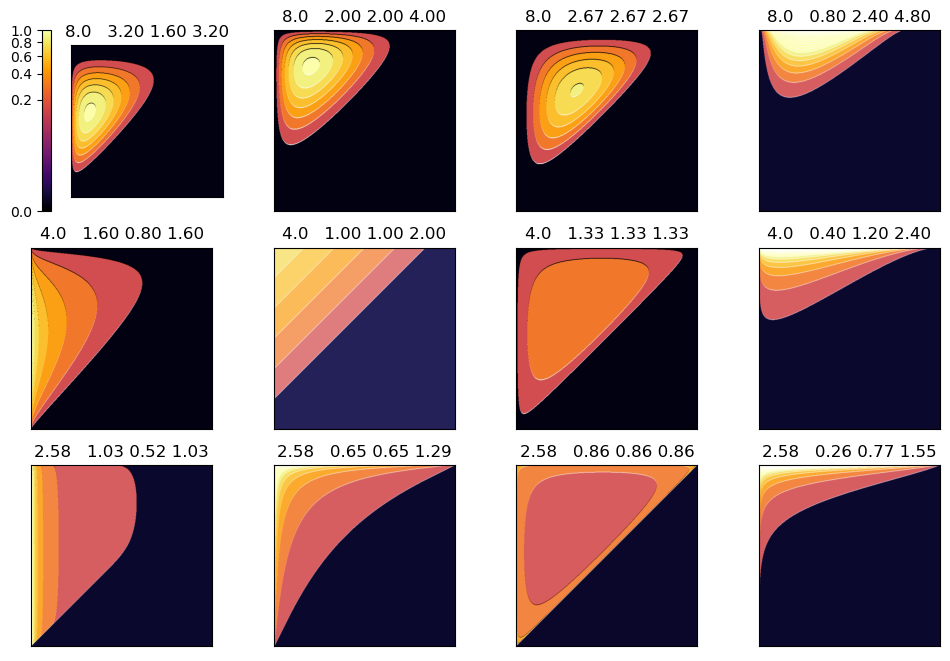

In [246]:
fig = plt.figure(figsize=(12,8)) 
light_cmap=plt.cm.inferno
#light_cmap = plt.cm.viridis
add_light_source = True
add_colorbar=False
##  Shift spectrum interval of color map

## For inferno, this shifts down toward red (lower) end of the color map
norm= "power"
norm2="power"
## For inferno, this shifts up toward yellow (upper) end of the color map
#norm = "log"
# Light comes directly from the south.  Seems to create the fewest spurious shadows.
azdeg=180
draw_image_matrix (W, fig, add_light_source=add_light_source,light_cmap=light_cmap,norm=norm,
                   norm2=norm2,azdeg=azdeg,add_colorbar=add_colorbar)


### No light source

Possibly better because normalization works to give good resolution
and no spurious shadow effects.

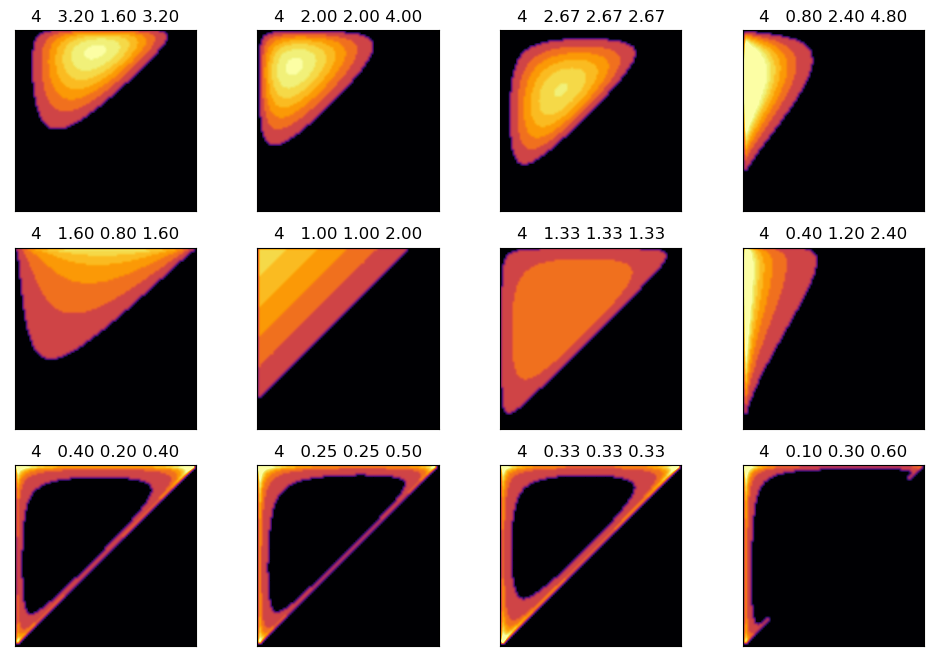

In [11]:

fig = plt.figure(figsize=(12,8)) 
#cmap="inferno"
#cmap= "viridis"
cmap = plt.cm.inferno
#cmap = plt.cm.viridis
add_light_source = False

#norm2= "log"
norm2="power"
draw_image_matrix (W, fig, add_light_source=add_light_source,cmap=cmap,norm2=norm2)


###  No light source (again) Sue Liu's alphas

Reproducing Sue Liu's alphas with no light source and the imshow implementation (using the same 
W as use with pcolormesh and assumed by `draw_image_matrix`).

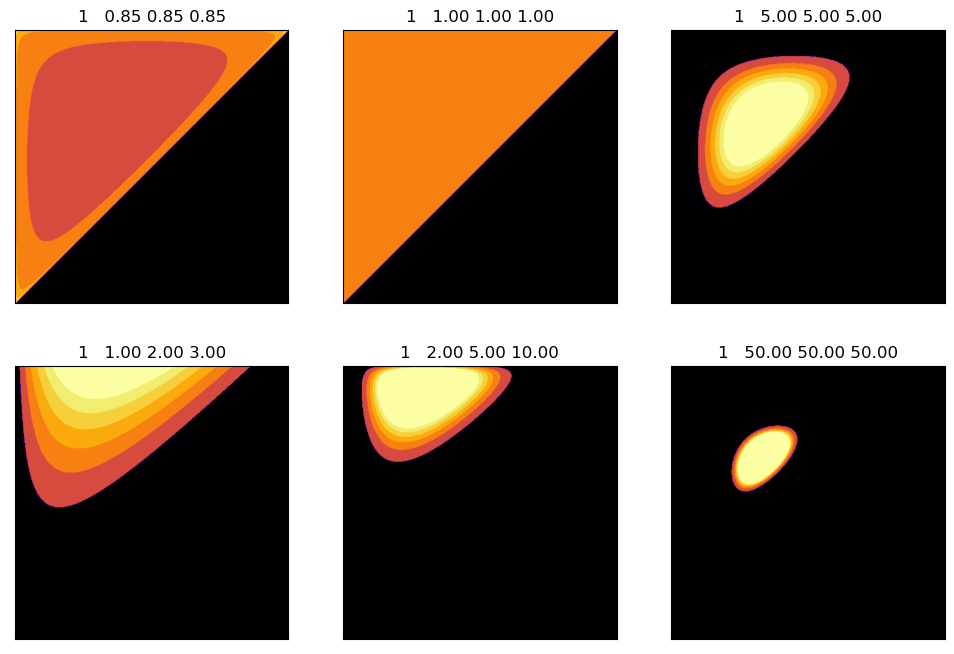

In [103]:
fig = plt.figure(figsize=(12,8)) 
cmap=plt.cm.inferno
#norm2=None works pretty good as well.
alphas = np.array([[.85,.85,.85],[1,1,1],[5,5,5],[1,2,3],[2,5,10],[50,50,50]])
draw_image_matrix (W, fig, add_light_source=False,cmap=cmap,
                   azdeg=azdeg,alphas=alphas,norm2="power")


###  Using pcolormesh (sketch)

Note:  Instead of using imshow one can also use pcolormesh and use the same matrix
`W` assumed by draw_image_matrix.

The following code cell illustrates the basic idea on a sample alpha, in fact the alpha
rendered in the first row and first column of the plot grid above. The simplex is flipped but
the same information seems to be there.

In [149]:
#print(ax.pcolormesh.__doc__)

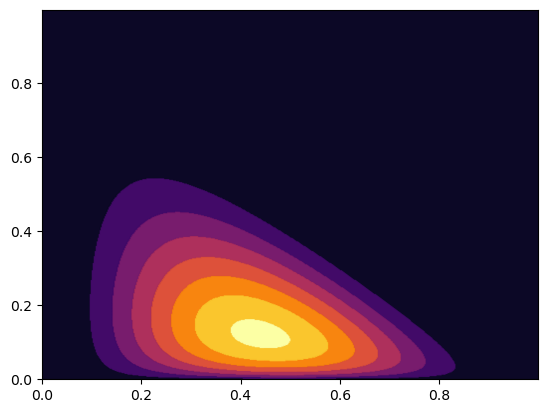

In [194]:
# number of desired meshpoints along one axis.
n=500
N=1/n
xv, yv = np.mgrid[0:1:N, 0:1:N]
W = np.concatenate([xv.reshape((n,n,1)),yv.reshape((n,n,1))],axis=2)
alpha = 8*np.array([.4,.2,.4])
zv = np.apply_along_axis(f,arr=W,axis=2)
#shading='nearest'
shading = "gouraud"
fig, ax = plt.subplots(1, 1)
cmap=plt.cm.inferno
use_log_colornorm=False

# xv,yv, and zv all need to be 2D arrays in meshgrid form.
# zv contains the values of a function applied to the x and y values in xv and yv.
# Using a 
if use_log_colornorm:
    ax.pcolormesh(xv, yv, zv, cmap=cmap, shading= shading,
                  norm= colors.LogNorm(vmin=0.01, vmax=zv.max()))
else:
    #using vmin -.5 to shift color spectrum
    ax.pcolormesh(xv, yv, zv, cmap=cmap, shading= shading,
                   vmin=-.5, vmax=zv.max())